[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - Forecasting a Sine Wave
## A project on Knowledge Distillation
### By Sean M. Venadas
### With help from: Skye Gunasekaran, Jason Eshraghian

This student-made tutorial was made for the class ECE183 (F2023) as part of UC Santa Cruz. It is only a small portion of a bigger project -- predicting
seizures throught the use of SNNs on EEG signals. This subset project was
designed to practice implementing methods of regression (KL Divergence and MSE) to student-teacher models. We specifically used SNNs (compared to NNs) because of its temporal advantages and ability to compute data more quickly and accurately. If you have any questions, please consider emailing me: svenadas@ucsc.edu.

# Introduction

In this tutorial, you will:
* Generate a sinusoid signal
* Create a teacher-model to train two different student-models
* Implement MSE and KL Divergence to predict signal behaviors in the teacher-model
* Plot data to visualize and compare results

Install the required libraries by clicking into the following cell and pressing `Shift+Enter`.

In [19]:
!pip install snntorch

In [20]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

# 1. Set Up the Signals

In order to get started, we need to set up two sinusoid signals to represent the teacher and student. Assuming basic knowledge on Knowledge Distillation (KD), you should know that you want your teacher model to be bigger in architecture. This is because we want to give the student as much information as possible.

In [21]:
def generate_sinusoid_data(num_points, amplitude, frequency, phase, noise_std=0.1):
    t = np.linspace(0, 1, num_points, dtype=np.float32)
    sinusoid = amplitude * np.sin(2 * np.pi * frequency * t + phase)
    noisy_sinusoid = sinusoid + np.random.normal(0, noise_std, size=num_points)
    return t, noisy_sinusoid

# The parameters below can be edited to your liking
num_points = 100
amplitude_teacher, frequency_teacher, phase_teacher = 1.0, 2.5, 0.0
amplitude_student, frequency_student, phase_student = 1.0, 2.0, 0.5 #phase-shifted to test pattern detection

In [22]:
# Generates signals with specified parameters in previous cell
t_teacher, teacher_data = generate_sinusoid_data(num_points, amplitude_teacher, frequency_teacher, phase_teacher)
t_student, student_data = generate_sinusoid_data(num_points, amplitude_student, frequency_student, phase_student)

In [23]:
# Convert data to PyTorch tensors with dtype float32
t_teacher_tensor = torch.from_numpy(t_teacher).view(-1, 1).float()
teacher_data_tensor = torch.from_numpy(teacher_data).view(-1, 1).float()

t_student_tensor = torch.from_numpy(t_student).view(-1, 1).float()
student_data_tensor = torch.from_numpy(student_data).view(-1, 1).float()

# 2. Define the Models

Filler

## 2.1 Teacher Model

In [46]:
lr = 0.001
epochs = 300

class TeacherSinusoidModel(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps=100, hidden=100):
        super().__init__()

        self.timesteps = timesteps # number of time steps to simulate the network
        self.hidden = hidden # number of hidden neurons
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # layer 1 (input layer)
        beta1 = torch.rand(self.hidden)
        thr1 = torch.rand(self.hidden)
        self.fc1 = torch.nn.Linear(in_features=1, out_features=self.hidden)
        self.lif1 = snn.Leaky(beta=beta1, threshold=thr1, learn_beta=True, spike_grad=spike_grad)

        # layer 2 (hidden layer)
        beta2 = torch.rand(self.hidden)
        thr2 = torch.rand(self.hidden)
        self.fc2 = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif2 = snn.Leaky(beta=beta2, threshold=thr2, learn_beta=True, spike_grad=spike_grad)

        # layer 3 (hidden layer)
        beta3 = torch.rand(self.hidden)
        thr3 = torch.rand(self.hidden)
        self.fc3 = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif3 = snn.Leaky(beta=beta3, threshold=thr3, learn_beta=True, spike_grad=spike_grad)

        # layer 4 (hidden layer)
        beta4 = torch.rand(self.hidden)
        thr4 = torch.rand(self.hidden)
        self.fc4 = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif4 = snn.Leaky(beta=beta4, threshold=thr4, learn_beta=True, spike_grad=spike_grad)

        # layer 5 (hidden layer)
        beta5 = torch.rand(self.hidden)
        thr5 = torch.rand(self.hidden)
        self.fc5 = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif5 = snn.Leaky(beta=beta5, threshold=thr5, learn_beta=True, spike_grad=spike_grad)

        # layer 6 (output layer)
        beta6 = torch.rand(1)
        # layer 6: leaky integrator neuron. Note the reset mechanism is disabled and we will disregard output spikes.
        self.fc6 = torch.nn.Linear(in_features=self.hidden, out_features=1)
        self.lif6 = snn.Leaky(beta=beta6, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none")

    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()
        mem6 = self.lif6.init_leaky()

        # Empty lists to record outputs
        mem6_rec = []

        # Loop over
        for step in range(self.timesteps):
            x_timestep = x[step, :]

            cur1 = self.fc1(x_timestep)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            cur4 = self.fc4(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)

            cur5 = self.fc5(spk4)
            spk5, mem5 = self.lif5(cur5, mem5)

            cur6 = self.fc6(spk5)
            _, mem6 = self.lif6(cur6, mem6)

            mem6_rec.append(mem6)

        return torch.stack(mem6_rec)

## 2.2 Student Model

In [47]:
class StudentSinusoidModel(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps=100, hidden=100):
        super().__init__()

        self.timesteps = timesteps # number of time steps to simulate the network
        self.hidden = hidden # number of hidden neurons
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # randomly initialize decay rate and threshold for layer 1
        beta_in = torch.rand(self.hidden)
        thr_in = torch.rand(self.hidden)

        # layer 1
        self.fc_in = torch.nn.Linear(in_features=1, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta_in, threshold=thr_in, learn_beta=True, spike_grad=spike_grad)

        # randomly initialize decay rate and threshold for layer 2
        beta_hidden = torch.rand(self.hidden)
        thr_hidden = torch.rand(self.hidden)

        # layer 2
        self.fc_hidden = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif_hidden = snn.Leaky(beta=beta_hidden, threshold=thr_hidden, learn_beta=True, spike_grad=spike_grad)

        # randomly initialize decay rate for output neuron
        beta_out = torch.rand(1)

        # layer 3: leaky integrator neuron. Note the reset mechanism is disabled and we will disregard output spikes.
        self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=1)
        self.li_out = snn.Leaky(beta=beta_out, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none")

    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem_1 = self.lif_in.init_leaky()
        mem_2 = self.lif_hidden.init_leaky()
        mem_3 = self.li_out.init_leaky()

        # Empty lists to record outputs
        mem_3_rec = []

        # Loop over
        for step in range(self.timesteps):
            x_timestep = x[step, :]

            cur_in = self.fc_in(x_timestep)
            spk_in, mem_1 = self.lif_in(cur_in, mem_1)

            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_2 = self.lif_hidden(cur_hidden, mem_2)

            cur_out = self.fc_out(spk_hidden)
            _, mem_3 = self.li_out(cur_out, mem_3)

            mem_3_rec.append(mem_3)

        return torch.stack(mem_3_rec)

# 3. Implement Knowledge Distillation

Filler

## 3.1 Evaluate the Models

Filler

In [48]:
def evaluate_model(model, input_data, target_data):
    model.eval()
    with torch.no_grad():
        predictions = model(input_data)
        mse = nn.functional.mse_loss(predictions, target_data)
    return mse.item()

## 3.2 Create the Teacher Model

In [49]:
# Create teacher model
teacher_model = TeacherSinusoidModel()

# Loss function without KL divergence term
criterion_teacher = nn.MSELoss()

# Create optimizer for teacher model
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=lr)

# Train the teacher model on teacher data
for epoch in range(epochs):
    teacher_optimizer.zero_grad()
    teacher_output = teacher_model(t_teacher_tensor)
    loss_teacher = criterion_teacher(teacher_output, teacher_data_tensor)
    loss_teacher.backward()
    teacher_optimizer.step()

# Get logits from the teacher model
teacher_logits = teacher_model(t_teacher_tensor)

## 3.3 Create the Student Models

Filler

In [50]:
# Define the temporary student model

# Create temporary student model
temp_student_model = StudentSinusoidModel()

# Loss function with MSE
def custom_loss2(y_true, y_pred):
    mse_loss = nn.functional.mse_loss(y_true, y_pred)
    return mse_loss

# Create optimizer for temporary student model
temp_student_optimizer = optim.Adam(temp_student_model.parameters(), lr=lr)

# Train the temporary student model on student data
for epoch in range(epochs):
    temp_student_optimizer.zero_grad()
    temp_student_output = temp_student_model(t_student_tensor)
    loss_temp_student = custom_loss2(student_data_tensor, temp_student_output)
    loss_temp_student.backward()
    temp_student_optimizer.step()

In [51]:
# Define the final student model

# Create final student model
student_model = StudentSinusoidModel()

# Loss function with KL divergence term
def custom_loss1(y_true, y_pred, teacher_logits):
    kl_loss = nn.functional.kl_div(F.log_softmax(y_pred, dim=1), F.softmax(teacher_logits, dim=1), reduction='batchmean')
    return kl_loss

# Create optimizer for student model
student_optimizer = optim.Adam(student_model.parameters(), lr=lr)

# Train the student model on student data with KL divergence term
for epoch in range(epochs):
    teacher_model.eval()
    student_optimizer.zero_grad()
    student_output = student_model(t_student_tensor)
    with torch.no_grad():
      teacher_logits = teacher_model(t_student_tensor)
    loss = custom_loss1(student_data_tensor, student_output, teacher_logits)
    loss.backward(retain_graph=True)  # Set retain_graph=True to allow multiple backward passes
    student_optimizer.step()

# 4. Results

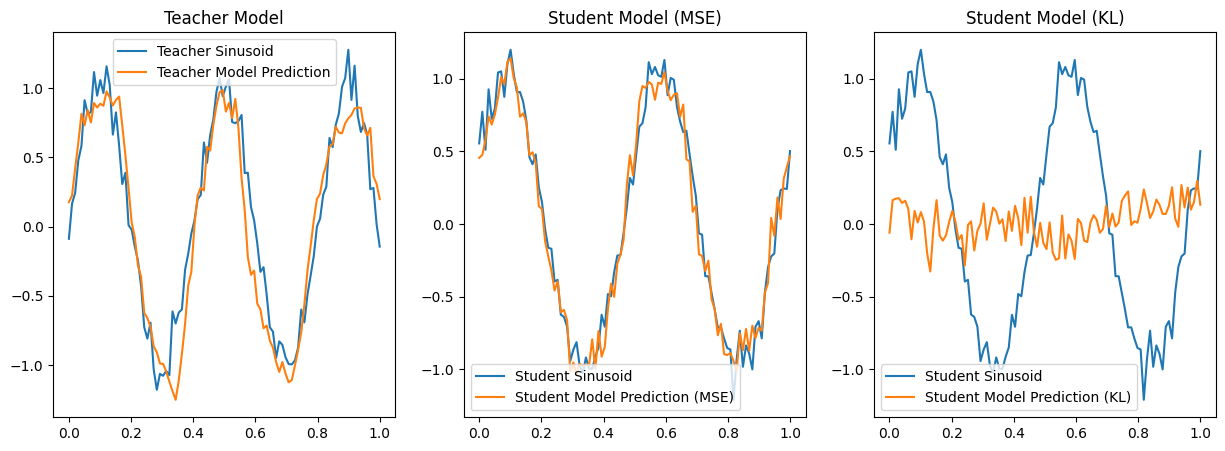

In [52]:
# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(t_teacher, teacher_data, label='Teacher Sinusoid')
plt.plot(t_teacher, teacher_model(t_teacher_tensor).detach().numpy(), label='Teacher Model Prediction')
plt.legend()
plt.title('Teacher Model')

plt.subplot(1, 3, 2)
plt.plot(t_student, student_data, label='Student Sinusoid')
plt.plot(t_student, temp_student_model(t_student_tensor).detach().numpy(), label='Student Model Prediction (MSE)')
plt.legend()
plt.title('Student Model (MSE)')

plt.subplot(1, 3, 3)
plt.plot(t_student, student_data, label='Student Sinusoid')
plt.plot(t_student, student_model(t_student_tensor).detach().numpy(), label='Student Model Prediction (KL)')
plt.legend()
plt.title('Student Model (KL)')

plt.show()

In [53]:
# Evaluate Teacher Model
mse_teacher = evaluate_model(teacher_model, t_teacher_tensor, teacher_data_tensor)
print(f"MSE for Teacher Model:        {mse_teacher}")

# Evaluate Base Student Model
mse_temp_student = evaluate_model(temp_student_model, t_student_tensor, student_data_tensor)
print(f"MSE for Student Model (MSE):  {mse_temp_student}")

# Evaluate Student Model with Temporal Distillation
mse_student = evaluate_model(student_model, t_student_tensor, student_data_tensor)
print(f"MSE for Student Model (KL):   {mse_student}")

MSE for Teacher Model:        0.05495592579245567
MSE for Student Model (MSE):  0.014743178151547909
MSE for Student Model (KL):   0.5931049585342407
